## Background
This notebook delves into the effectiveness of various email campaigns in generating clicks. Campaigns can be configured with either short or long versions of email content, containing either generic or personalized messages. Personalized content entails the inclusion of the recipient's name in the email.

I've got three data files at hand, which is:

**email**: The table that contains all campaign emails sent to users
* email_id: unique identifier for an email campaign
* email_text: `short_email` or `long_email`
* email_version: `personalized` or `generic`
* hour: the hour of the day when email was sent
* weekday:the day of the week when email was sent
* user_country: `US`, `UK`, `ES`, `FR`
* user_past_purchases: past purchases before sending this email

**open**: The table contains all the emails that were opened
* email_id

**click**: The table contains all the emails that were clicked
* email_id

Above three tables could be merged via `email_id`.

In this notebook, I'll clean the data and then explore the data by a few visualizations. I'll also train a Machine Learning model to predict if a user will click the links in the email or not.

In [1]:
import os
import pandas as pd

In [2]:
BASE_PATH = "dataset"
EMAIL_FILE = "email_table.csv"
OPEN_FILE = "email_opened_table.csv"
CLICK_FILE = "link_clicked_table.csv"

df_email = pd.read_csv(os.path.join(BASE_PATH, EMAIL_FILE))
df_open = pd.read_csv(os.path.join(BASE_PATH, OPEN_FILE))
df_click = pd.read_csv(os.path.join(BASE_PATH, CLICK_FILE))

In [3]:
df_email.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


In [4]:
df_open.head()

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


In [5]:
df_click.head()

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


## Preprocessing

Let's do some data quality check before merging these datasets.

In [6]:
# Check record duplicates

print(
    "Number of duplicated records:", 
    df_email.duplicated().sum(),
    df_open.duplicated().sum(),
    df_click.duplicated().sum()
)

Number of duplicated records: 0 0 0


In [7]:
# Check duplicates of primary and foreign key

print(
    "Number of duplicated keys:",
    df_email.email_id.duplicated().sum(),
    df_open.email_id.duplicated().sum(),
    df_click.email_id.duplicated().sum()
)

Number of duplicated keys: 0 0 0


In [8]:
# Check missing data

print(
    "Number of missing cells:",
    df_email.isnull().sum().sum(),
    df_open.isnull().sum().sum(),
    df_click.isnull().sum().sum()
)


Number of missing cells: 0 0 0


In [9]:
# Check data types

df_email.dtypes

email_id                int64
email_text             object
email_version          object
hour                    int64
weekday                object
user_country           object
user_past_purchases     int64
dtype: object

In [10]:
df_open.dtypes

email_id    int64
dtype: object

In [11]:
df_click.dtypes

email_id    int64
dtype: object

In [12]:
# Merge datasets

df_open["is_opened"] = 1
df_click["is_clicked"] = 1

df = (
    df_email
    .merge(df_open, on="email_id", how="left")
    .merge(df_click, on="email_id", how="left")
    .fillna(0)
    .astype({
        "is_opened": int,
        "is_clicked": int,
    })
)

df.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,is_opened,is_clicked
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0


In [13]:
# Check if left join introduces duplicates

df.shape[0] == df_email.shape[0]

True

## Explorary Data Analysis
Next, I'll do some quick visualized explorations.

### Univariate analysis

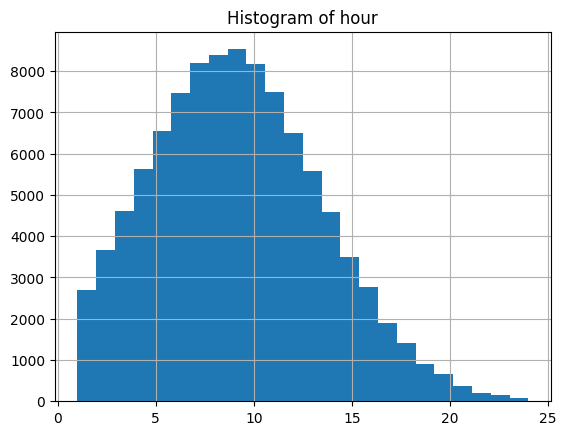

In [14]:
import matplotlib.pyplot as plt

df.hour.hist(bins=24)
plt.title("Histogram of hour")
plt.show()

The histogram of hour is right skewed. Most of the emails were sent during the day time.

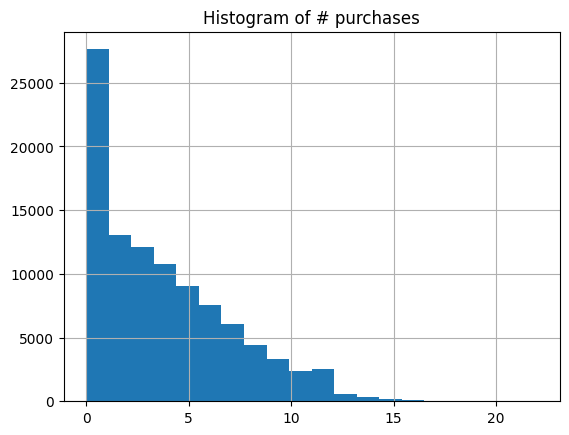

In [15]:
df.user_past_purchases.hist(bins=20)
plt.title("Histogram of # purchases")
plt.show()

Obviously it is right skewed, and most of the users have not any purchases.

In [16]:
df.columns

Index(['email_id', 'email_text', 'email_version', 'hour', 'weekday',
       'user_country', 'user_past_purchases', 'is_opened', 'is_clicked'],
      dtype='object')

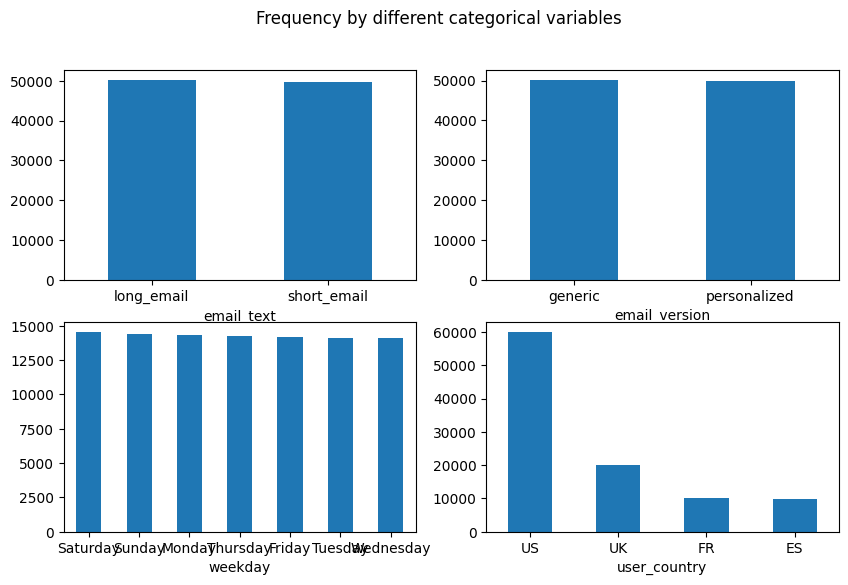

In [17]:
cols_cat = [
    "email_text",
    "email_version",
    "weekday",
    "user_country",
]

fig, axes = plt.subplots(2, 2, figsize=(10, 6))

for i in range(len(cols_cat)):
    ax = axes[i//2, i%2]
    tmp = df[cols_cat[i]].value_counts().plot(kind="bar", ax=ax)
    ax.tick_params(axis="x", rotation=0)

plt.suptitle("Frequency by different categorical variables")
plt.show()

Most of them are quite even, except for `user_country`. Most emails were sent to users in US.

### Bivariate analysis

We're mostly interested in open and click rate. Let's see how it differs among different dimensions.

In [18]:
df.columns

Index(['email_id', 'email_text', 'email_version', 'hour', 'weekday',
       'user_country', 'user_past_purchases', 'is_opened', 'is_clicked'],
      dtype='object')

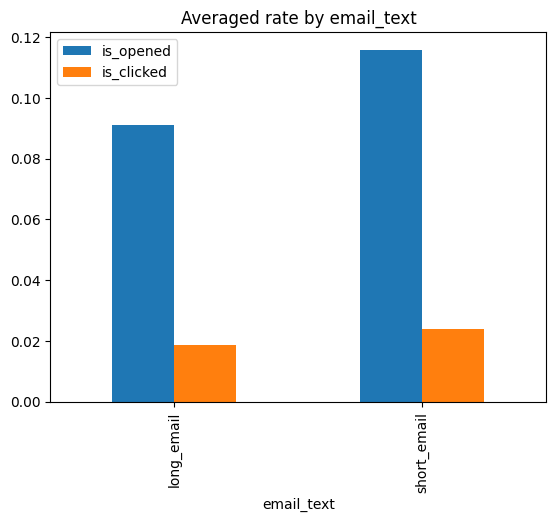

In [19]:
# Check by email_text
def metrics_by_categorical(dim):
    """
    Helper function to plot metrics by a categorical variable
    """
    cols = ["is_opened", "is_clicked"]
    cols.append(dim)
    df[cols].groupby(dim).mean().plot(kind="bar")
    plt.title(f"Averaged rate by {dim}")
    plt.show()

metrics_by_categorical("email_text")

Short emails tend to have a little bit higher open and click rate.

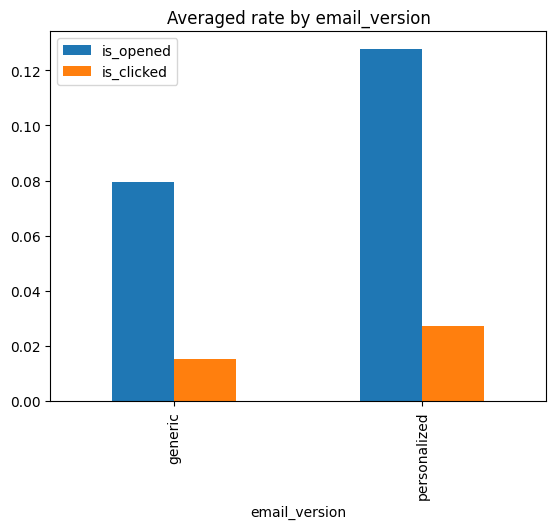

In [20]:
# Check by email version
metrics_by_categorical("email_version")

Not surprisingly, personalized emails have higher open and click rate.

/var/folders/xw/6gj5qs_s6tgc6_3s78fptdy80000gn/T/ipykernel_10601/1448567297.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[cols].groupby(dim).mean().plot(kind="bar")


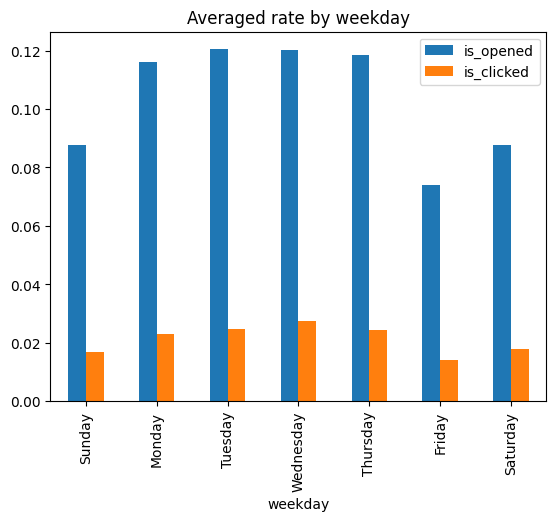

In [21]:
# Make sure days of week are ordered properly
wd_order = [
    "Sunday",
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday"
]

df.weekday = pd.Categorical(df.weekday, categories=wd_order, ordered=True)

# Check by day of week
metrics_by_categorical("weekday")

Friday, Saturday and Sunday has lower performance probably because people don't check emails near or during weekends.

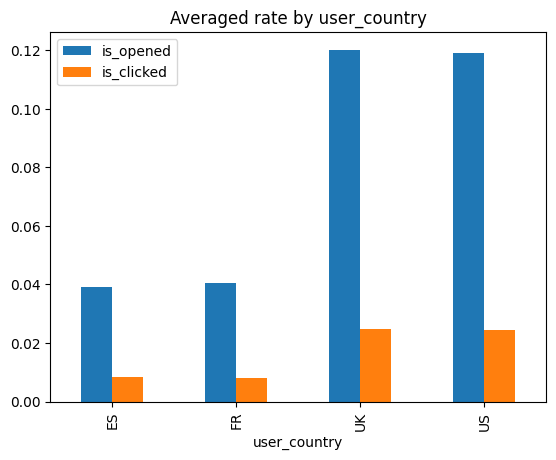

In [22]:
# Check by user country
metrics_by_categorical("user_country")

US and UK has much higher open and click rate. It's good to see US has both highest email sends and one of the highest open and click rates.

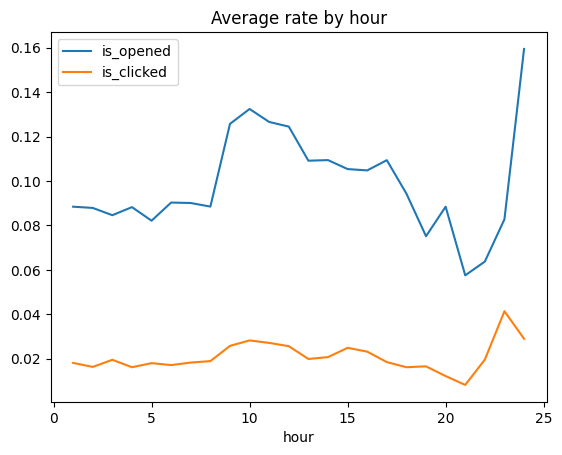

In [23]:
def metric_by_numerical(dim):
    """
    Helper function to plot metrics by a numerical variable
    """
    cols = ["is_opened", "is_clicked"]
    cols.append(dim)
    df[cols].groupby(dim).mean().plot(kind="line")
    plt.title(f"Average rate by {dim}")
    plt.show

# Check by hour
metric_by_numerical("hour")

We could see two spikes. One is around 10 and the other is round 23, which are 1. the beginning of a working day, and 2. the moment before going to bed.

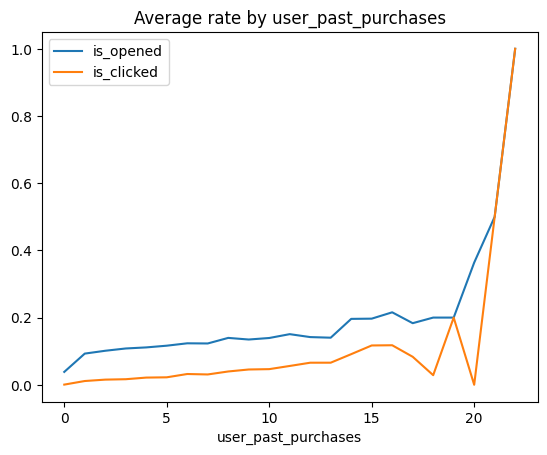

In [24]:
# Check by purchases
metric_by_numerical("user_past_purchases")

Not surprisingly, more purchases, higher open and click rate.

## Model Training
### Feature engineering and data preparation

In [25]:
# Split train / test dataset
from sklearn.model_selection import train_test_split

df_copy = df.copy(deep=True)

y = df["is_clicked"] # Target variable

# Remove is_open as we don't know if an email will be opened at the moment of sending it
# Remove email_id as it isn't informative
X = df.drop(columns=["is_clicked", "is_opened", "email_id"])

# As the target variable is highly unbalanced, I decide to stratify the split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [26]:
# Verify the distribution of the target variable
print("Average click rate for train set", y_train.mean())
print("Average click rate for test set", y_test.mean())

Average click rate for train set 0.0211875
Average click rate for test set 0.0212


Very close! Looks like the `stratify` parameter works perfectly.

In [27]:
# Set up the feature engineering pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Numerical columns
# I decided to keep hours as it is
cols_num = ["user_past_purchases"]

# Categorical columns
cols_cat = [
    "email_text",
    "email_version",
    "weekday",
    "user_country",
]

# Standardize numerical variables
pipe_num = Pipeline(steps=[
    ("scale", StandardScaler())
])

# Encode categorical variables
pipe_cat = Pipeline(steps=[
    ("one-hot", OneHotEncoder())
])

col_trans = ColumnTransformer(
    transformers=[
        ("numerical", pipe_num, cols_num),
        ("categorical", pipe_cat, cols_cat),
    ],
    remainder="passthrough",
    n_jobs=-1
)


In [28]:
# Take a look at the pipeline
display(col_trans)

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('numerical',
                                 Pipeline(steps=[('scale', StandardScaler())]),
                                 ['user_past_purchases']),
                                ('categorical',
                                 Pipeline(steps=[('one-hot', OneHotEncoder())]),
                                 ['email_text', 'email_version', 'weekday',
                                  'user_country'])])

In [29]:
# Let's do a quick test on a few categorical models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score
from time import time
import numpy as np

models = [
    LogisticRegression,
    DecisionTreeClassifier,
    RandomForestClassifier,
    XGBClassifier,
]

for model in models:
    start_time = time()

    pipe_model = Pipeline(steps=[
        ("col_trans", col_trans),
        ("model", model()),
    ])
    
    score = cross_val_score(
        pipe_model,
        X_train,
        y_train,
        cv=3,
        scoring="f1", # balance of precision and recall
    )

    end_time = time()

    print(
        f"Training on model: {model.__name__}\t",
        f"F1 score: {np.average(score):.4f}\t",
        f"Training time (seconds): {end_time - start_time:.1f}"
    )


Training on model: LogisticRegression	 F1 score: 0.0000	 Training time (seconds): 3.2
Training on model: DecisionTreeClassifier	 F1 score: 0.0258	 Training time (seconds): 2.0
Training on model: RandomForestClassifier	 F1 score: 0.0156	 Training time (seconds): 7.4
Training on model: XGBClassifier	 F1 score: 0.0046	 Training time (seconds): 1.3


Initial run doesn't have a good performance, and interestingly the Decision Tree has the best F1 score. In general ensemble models will have better performance. Let's take a closer look at the top 2 models: Decision Tree and Random Forest.

### Fine tune - Decision Tree

In [30]:
from sklearn.model_selection import RandomizedSearchCV

grid_params = {
    "model__max_depth": list(range(2, 10)),
    "model__min_samples_split": list(range(4, 5)),
    "model__min_samples_leaf": list(range(2, 5)),
    "model__class_weight": ["balanced"],
    "model__ccp_alpha": [i*0.01 for i in range(0, 11)],
    "model__random_state": [42]
}

pipe_dt = Pipeline(steps=[
    ("col_trans", col_trans),
    ("model", DecisionTreeClassifier())
])

grid_search_dt = RandomizedSearchCV(
    pipe_dt,
    grid_params,
    n_iter=20,
    cv=5,
    n_jobs=-1,
    scoring="f1",
    random_state=42,
)

grid_search_dt.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('col_trans',
                                              ColumnTransformer(n_jobs=-1,
                                                                remainder='passthrough',
                                                                transformers=[('numerical',
                                                                               Pipeline(steps=[('scale',
                                                                                                StandardScaler())]),
                                                                               ['user_past_purchases']),
                                                                              ('categorical',
                                                                               Pipeline(steps=[('one-hot',
                                                                                                OneHotEncoder())]),
                                                                               ['email_text',
                                                                                'email_version',
                                                                                'weekday',
                                                                                'user_country'])])),
                                             ('model',
                                              DecisionTreeClassifier())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'model__ccp_alpha': [0.0, 0.01, 0.02,
                                                             0.03, 0.04, 0.05,
                                                             0.06, 0.07, 0.08,
                                                             0.09, 0.1],
                                        'model__class_weight': ['balanced'],
                                        'model__max_depth': [2, 3, 4, 5, 6, 7,
                                                             8, 9],
                                        'model__min_samples_leaf': [2, 3, 4],
                                        'model__min_samples_split': [4],
                                        'model__random_state': [42]},
                   random_state=42, scoring='f1')

In [31]:
best_dt = grid_search_dt.best_estimator_
best_dt_score = grid_search_dt.best_score_

print("Best F1 score for Decision Tree", best_dt_score)

Best F1 score for Decision Tree 0.06539649382325072


After tuning, the Decision Tree performs better than the default parameters. Let's take a deeper look.

In [32]:
pd.DataFrame({
    "feature": best_dt.named_steps["col_trans"].get_feature_names_out(),
    "importance": best_dt.named_steps["model"].feature_importances_
}).sort_values(by="importance", ascending=False)



,feature,importance
0,numerical__user_past_purchases,0.685894
3,categorical__email_version_generic,0.119894
12,categorical__user_country_ES,0.083825
13,categorical__user_country_FR,0.080866
16,remainder__hour,0.012969
6,categorical__weekday_Monday,0.007197
8,categorical__weekday_Sunday,0.005780
10,categorical__weekday_Tuesday,0.002468
15,categorical__user_country_US,0.000616
4,categorical__email_version_personalized,0.000490


Interesting... looks like past purchases is most important feature. Let's plot the tree structure.

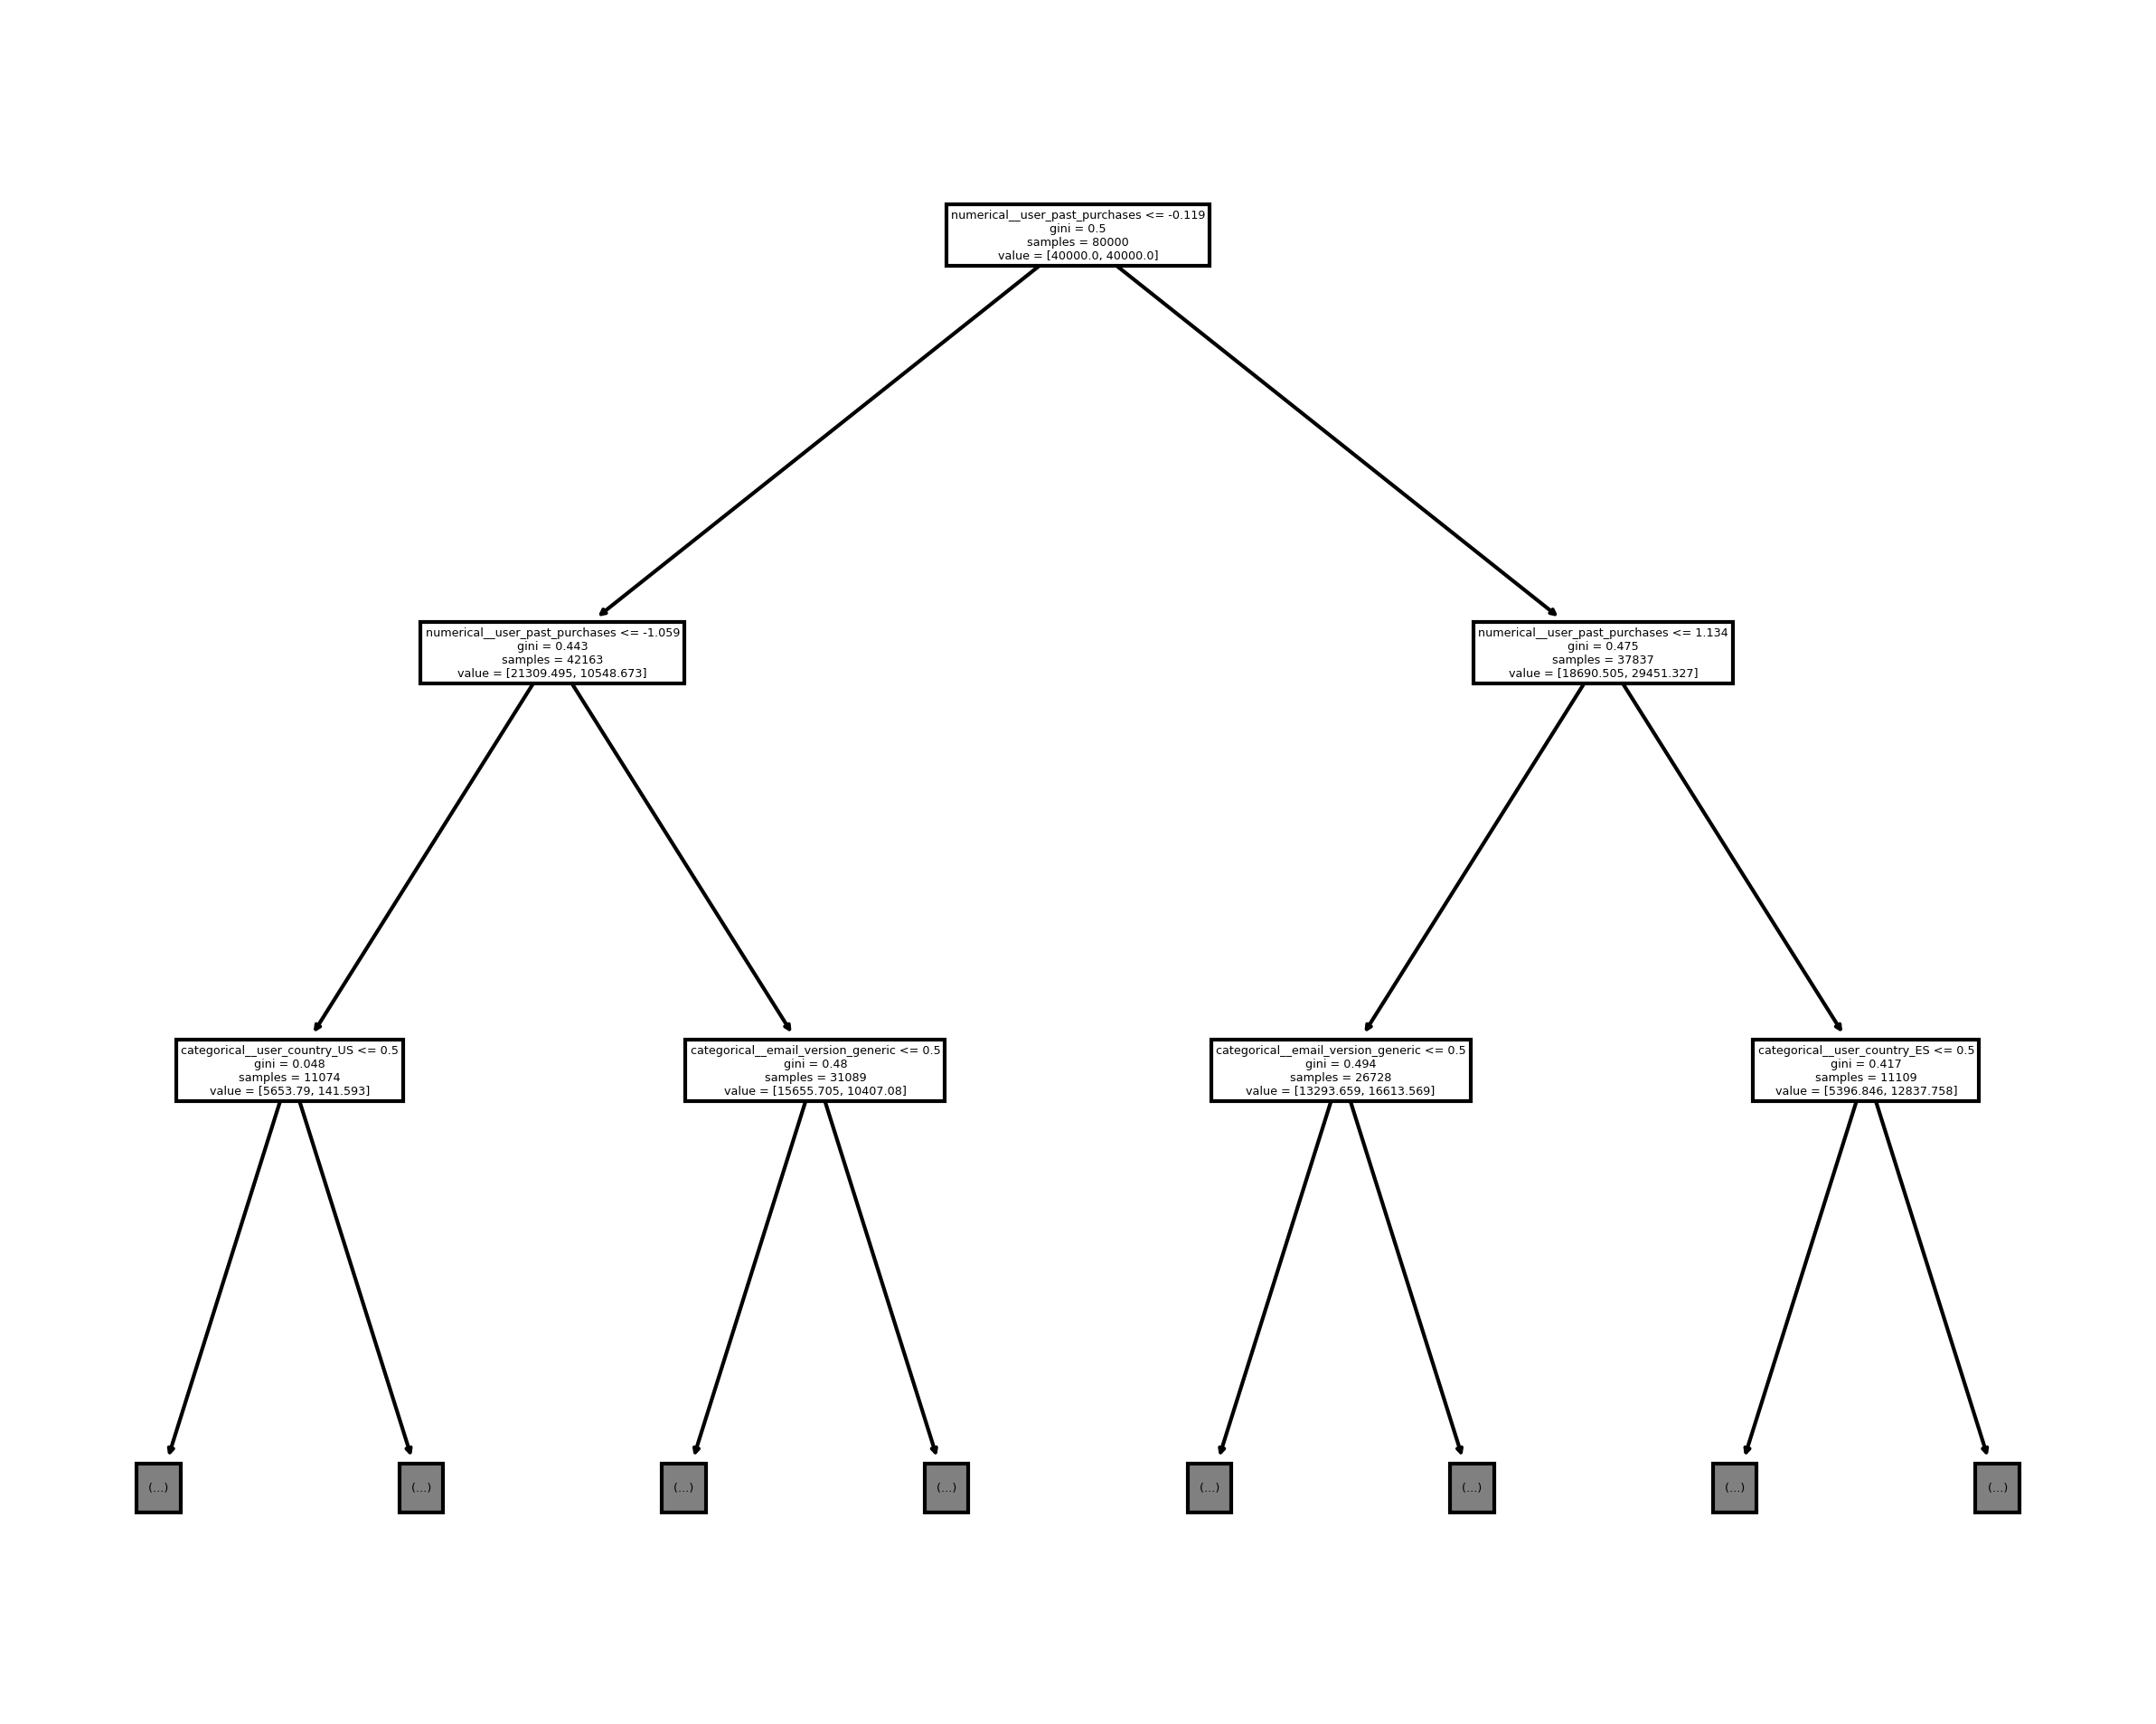

In [54]:
from sklearn.tree import plot_tree


plt.figure(figsize=(10, 8), dpi=300)
plot_tree(
    best_dt.named_steps["model"],
    feature_names=best_dt.named_steps["col_trans"].get_feature_names_out(),
    max_depth=2,
)
plt.show()

OK, the major split happens on the past purchases as well.

Let's see how this model works on the test dataset.

In [34]:
from sklearn.metrics import f1_score

f1_score(
    y_test,
    best_dt.predict(X_test)
)

0.06237919522052363

F1 score on the test dataset is very close to the one on training dataset

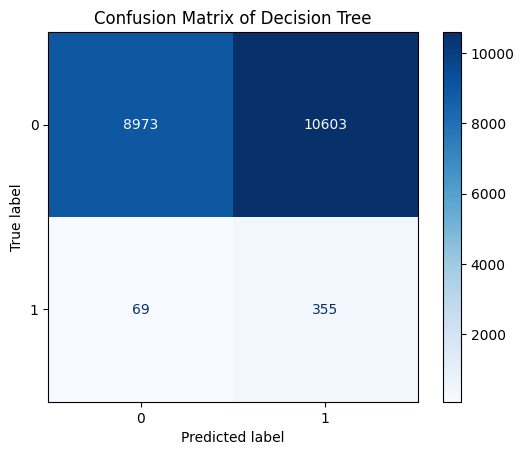

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    best_dt,
    X_test,
    y_test,
    cmap="Blues",
)
plt.title("Confusion Matrix of Decision Tree")
plt.show()

And if we send email campaigns to users only tagged 1 by this model, the click rate would be 3.2% (`355/(355+10603)`), which is better than sending to everyone (2.1%)

In [36]:
np.average(y_test)

0.0212

### Fine tune - Random Forest
Let's take a look at Random Forest as well.

In [37]:
grid_params = {
    "model__n_estimators": list(range(100, 1100, 100)),
    "model__max_depth": list(range(3, 11)),
    "model__min_samples_split": list(range(2, 11)),
    "model__min_samples_leaf": list(range(1, 6)),
    "model__oob_score": [True],
    "model__n_jobs": [-1],
    "model__random_state": [42],
    "model__class_weight": ["balanced"],
    "model__ccp_alpha": [0.01*i for i in range(0, 11)],
}

rf_pipe = Pipeline(steps=[
    ("col_trans", col_trans),
    ("model", RandomForestClassifier()),
])

grid_search_rf = RandomizedSearchCV(
    rf_pipe,
    grid_params,
    n_iter=20,
    scoring="f1",
    n_jobs=-1,
    cv=5,
    random_state=42
)

grid_search_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('col_trans',
                                              ColumnTransformer(n_jobs=-1,
                                                                remainder='passthrough',
                                                                transformers=[('numerical',
                                                                               Pipeline(steps=[('scale',
                                                                                                StandardScaler())]),
                                                                               ['user_past_purchases']),
                                                                              ('categorical',
                                                                               Pipeline(steps=[('one-hot',
                                                                                                OneHotEncoder())]),
                                                                               ['email_text',
                                                                                'email_version',
                                                                                'weekday',
                                                                                'user_country'])])),
                                             ('model',
                                              RandomFo...
                                                             0.06, 0.07, 0.08,
                                                             0.09, 0.1],
                                        'model__class_weight': ['balanced'],
                                        'model__max_depth': [3, 4, 5, 6, 7, 8,
                                                             9, 10],
                                        'model__min_samples_leaf': [1, 2, 3, 4,
                                                                    5],
                                        'model__min_samples_split': [2, 3, 4, 5,
                                                                     6, 7, 8, 9,
                                                                     10],
                                        'model__n_estimators': [100, 200, 300,
                                                                400, 500, 600,
                                                                700, 800, 900,
                                                                1000],
                                        'model__n_jobs': [-1],
                                        'model__oob_score': [True],
                                        'model__random_state': [42]},
                   random_state=42, scoring='f1')

In [38]:
best_rf = grid_search_rf.best_estimator_
best_rf_score = grid_search_rf.best_score_

print("Best F1 score for Random Forest", best_rf_score)

Best F1 score for Random Forest 0.07721763245458071


After tuning, Random Forest performs better than Decision Tree. Let's see the feature importances.

In [39]:
pd.DataFrame({
    "feature": best_rf.named_steps["col_trans"].get_feature_names_out(),
    "importance": best_rf.named_steps["model"].feature_importances_
})

,feature,importance
0,numerical__user_past_purchases,0.509431
1,categorical__email_text_long_email,0.017561
2,categorical__email_text_short_email,0.015754
3,categorical__email_version_generic,0.056072
4,categorical__email_version_personalized,0.051448
5,categorical__weekday_Friday,0.020186
6,categorical__weekday_Monday,0.009357
7,categorical__weekday_Saturday,0.010443
8,categorical__weekday_Sunday,0.013904
9,categorical__weekday_Thursday,0.009375


The model does leverage more features to predict. Let's inspect how different features affect model's predictions.

In [40]:
# View all the engineered feature names
best_rf.named_steps["col_trans"].get_feature_names_out().tolist()

['numerical__user_past_purchases',
 'categorical__email_text_long_email',
 'categorical__email_text_short_email',
 'categorical__email_version_generic',
 'categorical__email_version_personalized',
 'categorical__weekday_Friday',
 'categorical__weekday_Monday',
 'categorical__weekday_Saturday',
 'categorical__weekday_Sunday',
 'categorical__weekday_Thursday',
 'categorical__weekday_Tuesday',
 'categorical__weekday_Wednesday',
 'categorical__user_country_ES',
 'categorical__user_country_FR',
 'categorical__user_country_UK',
 'categorical__user_country_US',
 'remainder__hour']

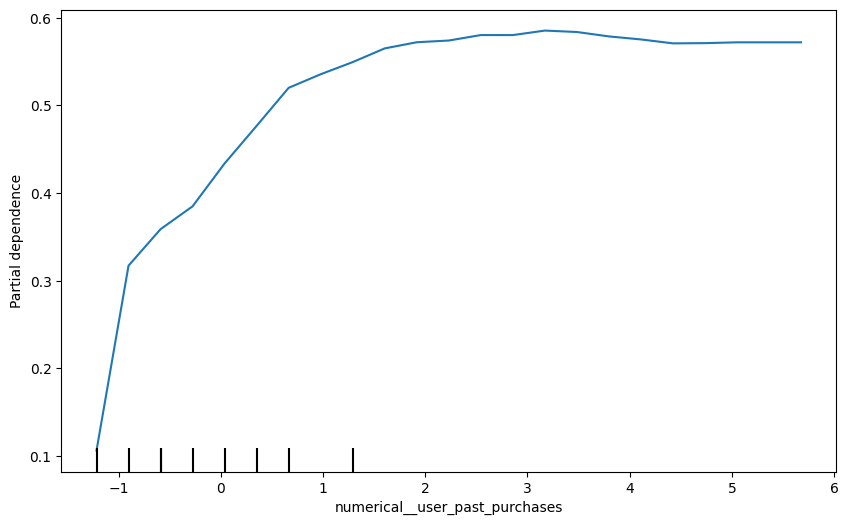

In [41]:
from sklearn.inspection import PartialDependenceDisplay

def plot_pdp_by(col_names):
    """
    Plot Partial Dependence Plot by col_names
    """
    all_feature_names = best_rf.named_steps["col_trans"].get_feature_names_out().tolist()
    n_cols = len(col_names)

    fig, axes = plt.subplots(figsize=(10, 6))

    PartialDependenceDisplay.from_estimator(
        best_rf.named_steps["model"],
        best_rf.named_steps["col_trans"].fit_transform(X_train),
        features=col_names,
        feature_names=all_feature_names,
        n_cols=n_cols,
        ax=axes,
    )

# Take a look at past purchases
col_to_plot = ["numerical__user_past_purchases"]
plot_pdp_by(col_to_plot)
    

Obviously see there's a huge difference between the scenario if a user has purchased at least once or not.

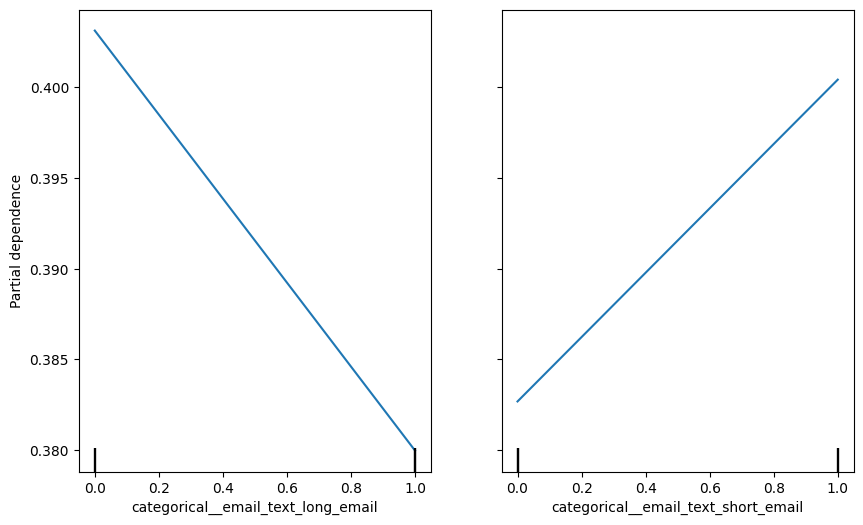

In [42]:
# Take a look at email version
col_to_plot = [
    "categorical__email_text_long_email",
    "categorical__email_text_short_email",
]

plot_pdp_by(col_to_plot)

Short email tends to have higher click rate.

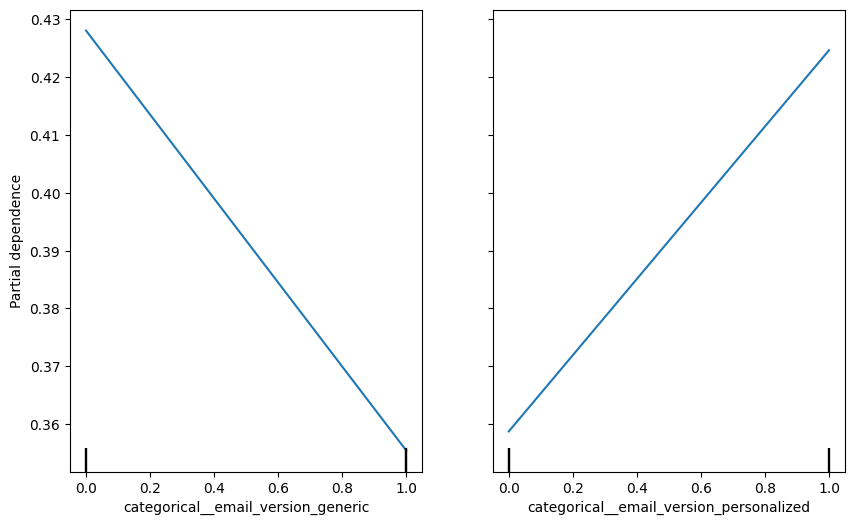

In [43]:
# Take a look at email version

col_to_plot = [
    "categorical__email_version_generic",
    "categorical__email_version_personalized",
]

plot_pdp_by(col_to_plot)

Personalized email tends to drive email clicks.

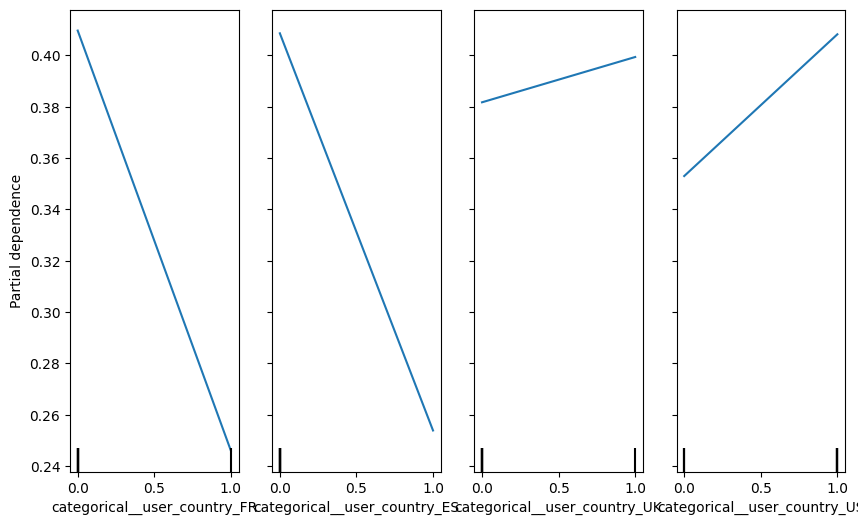

In [44]:
# Take a look at countries

col_to_plot = [
    "categorical__user_country_FR",
    "categorical__user_country_ES",
    "categorical__user_country_UK",
    "categorical__user_country_US",
]

plot_pdp_by(col_to_plot)

Similar to what we've observed during the exploratory data analysis, users in UK and US tend to click more often, and in contrast, FR and ES users don't.

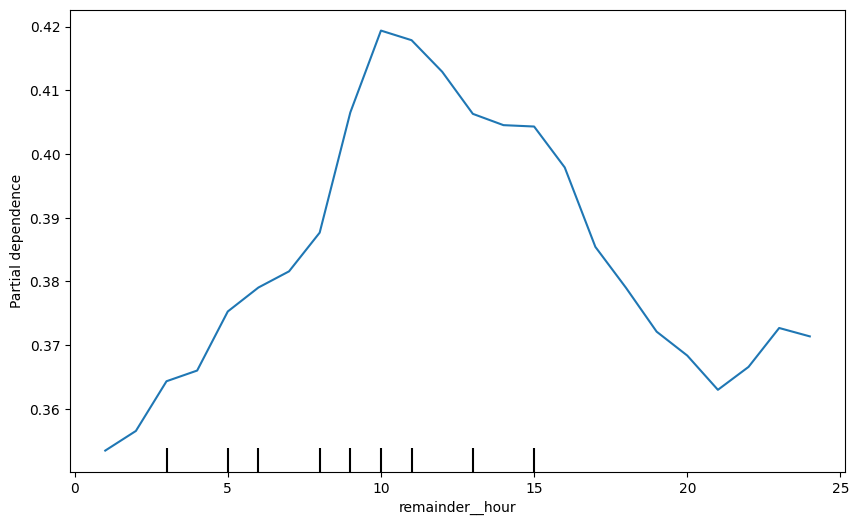

In [45]:
# Look at hour
col_to_plot = ["remainder__hour"]

plot_pdp_by(col_to_plot)

And 10am in the morning is definitely a sweet spot for email campaign.

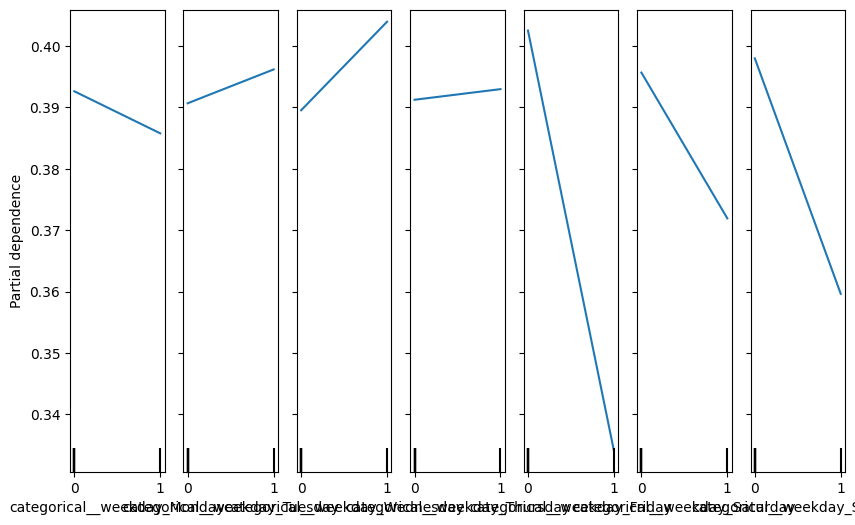

In [46]:
# Take a look at day of week

col_to_plot = [
    "categorical__weekday_Monday",
    "categorical__weekday_Tuesday",
    "categorical__weekday_Wednesday",
    "categorical__weekday_Thursday",
    "categorical__weekday_Friday",
    "categorical__weekday_Saturday",
    "categorical__weekday_Sunday",
]

plot_pdp_by(col_to_plot)

And a rule of thumb is to avoid sending Email campaigns on Friday or during the weekends. Better on Tuesday or Wednesday.

In [47]:
# Take a look at hyper-parameters

best_rf.named_steps["model"].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 400,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Compared to the tuned Decision Tree model, this Random Forest model is definitely more complex. The selected tree depth is 8.

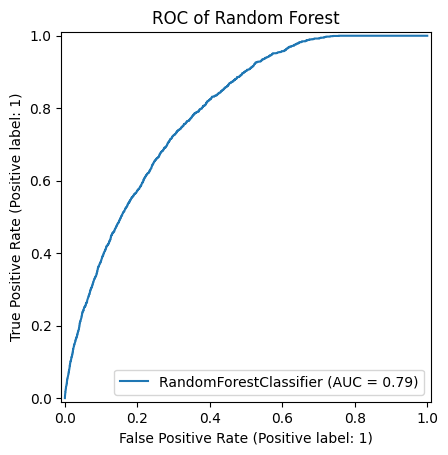

In [48]:
# Plot the ROC curve

from sklearn.metrics import RocCurveDisplay

rf_roc = RocCurveDisplay.from_estimator(
    best_rf.named_steps["model"],
    best_rf.named_steps["col_trans"].fit_transform(X_train),
    y_train
)

rf_roc
plt.title("ROC of Random Forest")
plt.show()

The corresponding AUC is 0.79. Let's see what's the best threshold of balancing TPR and FPR by selecting a point on the curve that is nearest to the top left corner.

In [49]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(
    y_train,
    best_rf.predict_proba(X_train)[:, 1]
)

rf_perf_df = pd.DataFrame({
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist(),
    "threshold": thresholds.tolist(),
})

rf_perf_df["distance"] = rf_perf_df.apply(
    lambda x: ((x.tpr-1)**2 + x.fpr**2)**0.5,
    axis=1
)

rf_perf_df.sort_values(by="distance", ascending=True).head()

,fpr,tpr,threshold,distance
5521,0.296916,0.722714,0.532441,0.406259
5532,0.297491,0.723304,0.532113,0.406278
5522,0.296954,0.722714,0.532304,0.406287
5538,0.298052,0.723894,0.531949,0.406288
5539,0.298078,0.723894,0.531911,0.406307


Looks like setting the threshold of `0.53` would have a relatively good performance leveraging both FPR and TPR. Let's plot it on the ROC curve as well.

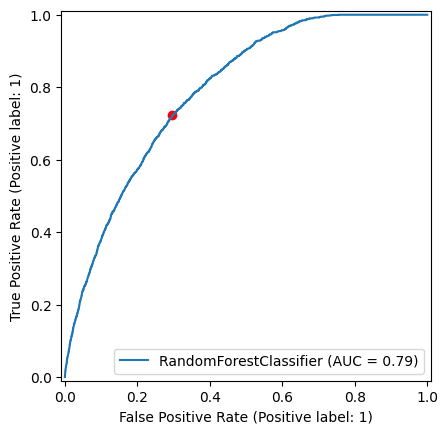

In [50]:
rf_roc.plot()
plt.scatter(0.296916, 0.722714, color="red")
plt.show()

Let's using this threshold to see how it performs on the test dataset.

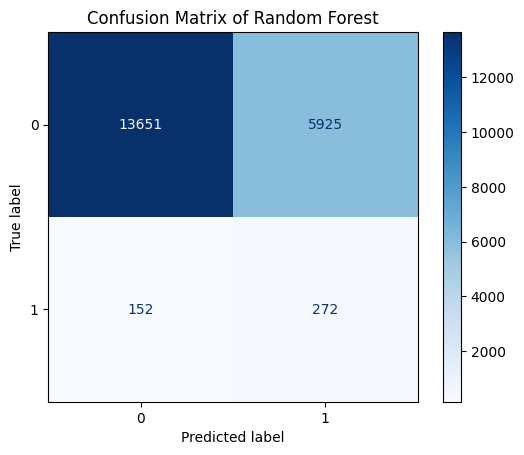

In [51]:
# Plot the confusion matrix
THRESHOLD = 0.53

y_pred = (best_rf.predict_proba(X_test) >= THRESHOLD)[:, 1].astype(int).tolist()
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    cmap="Blues",
)
plt.title("Confusion Matrix of Random Forest")
plt.show()

The Confusion Matrix indicates among all the users tagged likely to click (5925+272), actually 272 of them will click it. This means the click rate is around `4.4%`, which is better than the original `2.1%` and Decision Tree's `3.2%`. 

If we compare the Confusion Matrix between the Decision Tree and Random Forest model, we could see the True Positive numbers of the Random Forest model (number of users the model predicted to click actually clicked) are slightly lower, but it has way less misclassified users (False Positive cases), 5925 vs. 10603. This means the Random Forest model can more precisely predict the clicks.

## Summary

After exploring this Email campaign dataset, we found a few takeaways that would drive to a successful campaign event (in terms of click rate):
* Keep your email short
* Configure personalization if possible
* Send your emails around 10 am, and better to have it on Tuesday or Wednesday


If we select target users beforing sending emails with the help from a ML model's prediction, we would double our click rate (`4.4%` vs. `2.1%`), which means we'll more precisely target users who will tend to click, and try to avoid sending to those who won't click. This personalized engagement strategy will drive a balance between commercial objectives (clicks to transactions) and user experience (avoid unwanted touches).

We also found current customers (who have purchased at least once) tend to click the links in the email, compared with users who haven't made any purchases. This is a good news that we could relatively easily to engage (and potentially retain) current customers, but we should also take a deeper look why new users don't like to click. We could do a few quick checks on the campaign content or email style and see if that's friendly to new users.

Another interesting thing is the email campaign performs better in US and UK, but comparatively poor in ES and FR. This would also deserve a deep dive. How's the translation of the email campaign to users in ES or FR, which are not English speaking coutries? Or do users there have different preferences?

